In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

%matplotlib inline

In [3]:
mRNA_file = "./data/mRNA/out.tsv"
clinical_file = "./data/clinical/out.tsv"

In [4]:
t0 = time.time()
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
print(time.time()-t0)

60.505779504776


### Drop Genes with Null expression values

Considered
1. drop those genes
2. replace NaN with 0s

Since genes with nulls in them have completely different histogram compared to genes without nulls in them, 
the genes with nulls are dropped

In [5]:
# First compare the histogram of genes with Null Values and the genes without

In [6]:
transposed_df = mRNA_df.set_index("gene_id").transpose()
genes_with_nulls = transposed_df.columns[transposed_df.isnull().values.any(axis=0)]
genes_without_nulls = [i for i in transposed_df.columns if i not in genes_with_nulls]

In [7]:
hist_with_nulls = transposed_df[genes_with_nulls].as_matrix().flatten()
hist_with_nulls = np.array(list(filter(lambda x: not pd.isnull(x), hist_with_nulls)))

In [8]:
print(len(hist_with_nulls))

42472332


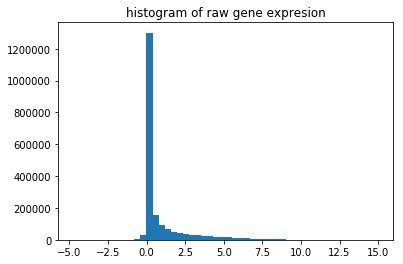

In [9]:
np.random.seed(5)
hist_with_nulls_sample = np.random.choice(hist_with_nulls, size=2000000)
hist_with_nulls_log = list(map(lambda x: np.log(x+1), hist_with_nulls_sample))
plt.hist(hist_with_nulls_log, bins=50)
plt.title("histogram of raw gene expresion")
plt.show()

In [19]:
def replace_with_zero(x):
    if pd.isnull(x):
        return 0
    else: return x

hist_with_nulls_replaced = hist_with_nulls = transposed_df[genes_with_nulls].as_matrix().flatten()
hist_with_nulls_replaced = np.array(list(map(replace_with_zero, hist_with_nulls_replaced)))

In [20]:
print(len(hist_with_nulls_replaced))

46445524


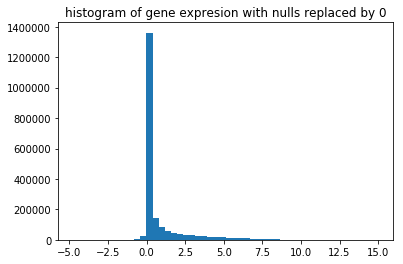

In [29]:
np.random.seed(1)
hist_with_nulls_replaced_sample = np.random.choice(hist_with_nulls_replaced, size=2000000)
hist_with_nulls_replaced_log = list(map(lambda x: np.log(x+1), hist_with_nulls_replaced_sample))
plt.hist(hist_with_nulls_replaced_log, bins=50)
plt.title("histogram of gene expresion with nulls replaced by 0")
plt.show()

### Log transformation

In [10]:
df = mRNA_df.dropna().set_index("gene_id").transpose()
df.index.name = "sample_id"

In [11]:
log_df = df.applymap(lambda x:np.log(x+1))

In [12]:
sample = np.random.choice(log_df.as_matrix().flatten(), size=1000000)

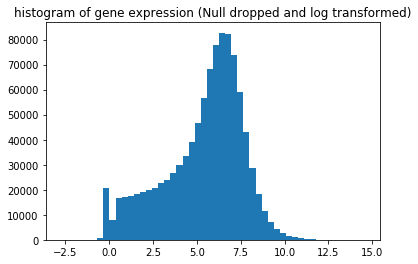

In [13]:
plt.hist(sample, bins=50)
plt.title("histogram of gene expression (Null dropped and log transformed)")
plt.show()

In [7]:
log_df.to_csv("./data/mRNA_lognorm.csv")

### Rescale data with MinMax, Standard and MaxAbs Scaler

In [8]:
def histogram_plotter(X, title):
    sample = np.random.choice(X.as_matrix().flatten(), size=1000000)
    plt.hist(sample, bins=50)
    plt.title(title)
    plt.show()

In [9]:
df = pd.read_csv("./data/mRNA_lognorm.csv", index_col="sample_id")

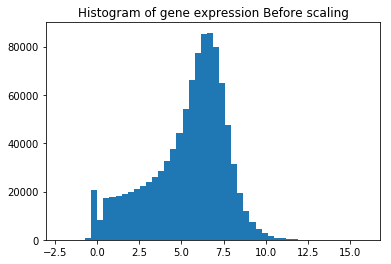

MinMax


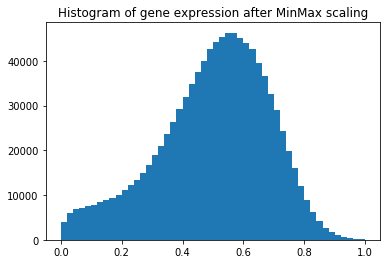

Standard


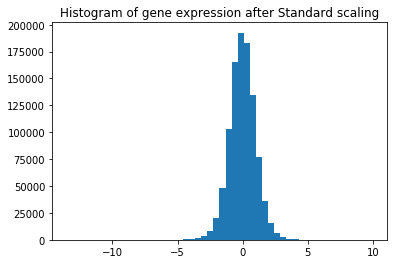

MaxAbs


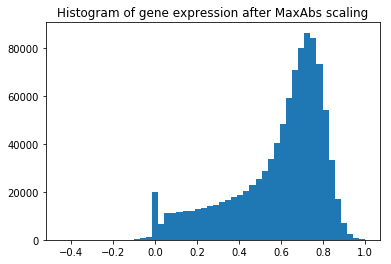

In [11]:
scaler_dict = {"MinMax": MinMaxScaler(), 
               "Standard": StandardScaler(), 
               "MaxAbs": MaxAbsScaler()}

histogram_plotter(df, "Histogram of gene expression Before scaling")

for scaler_name, scaler in scaler_dict.items():
    print(scaler_name)
    X_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    histogram_plotter(X_scaled, "Histogram of gene expression after {0} scaling".format(scaler_name))
    # X_scaled.to_csv("./data/mRNA_lognorm_{0}Scaled.csv".format(scaler_name))

### Extract labels
1. tissue of origin, 
2. gender 
3. tumor v.s. normal

#### 1 & 2 tissue and gender

In [61]:
def get_label(barcode, dic):
    patient_id = barcode[:12]
    if patient_id in dic:
        return dic[patient_id]
    else:
        return None

In [13]:
clinical_df = pd.read_csv(clinical_file, delimiter="\t", 
                          encoding="ISO-8859-1", low_memory=False)
df = pd.read_csv("./data/mRNA_lognorm_MinMaxScaled.csv")

In [69]:
tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
gender_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.gender))

In [70]:
label_df = pd.DataFrame(index=df.sample_id)
label_df["label_tissue"] = list(df.sample_id.apply(lambda x: get_label(x, tissue_dict)))
label_df["label_gender"] = list(df.sample_id.apply(lambda x: get_label(x, gender_dict)))

#### tumor v.s. normal label
Only save primary solid tumor, solid tumor normal and metastatic

In [100]:
CODE_DICT = {"01": "primary solid tumor",  
             "11": "solid tissue normal",
             "06": "metastatic",
             "03": "Primary Blood Derived Cancer - Peripheral Blood",
             "02": "Recurrent Solid Tumor",
             "05": "Additional - New Primary",
             "07": "Additional Metastatic"}

def extract_sample_type(barcode):
    return CODE_DICT[barcode.split("-")[3][:2]][:20]

In [101]:
label_df["label_tumor"] = list(df.sample_id.apply(extract_sample_type))

In [102]:
label_df.label_tumor.value_counts(dropna=False)

primary solid tumor     9706
solid tissue normal      737
metastatic               395
Primary Blood Derive     173
Recurrent Solid Tumo      46
Additional - New Pri      11
Additional Metastati       1
Name: label_tumor, dtype: int64

### Look at Label distributions

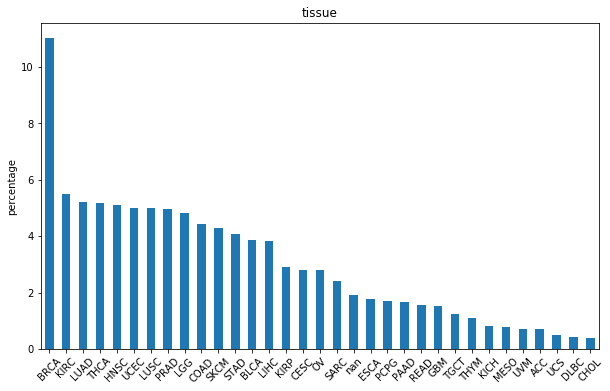

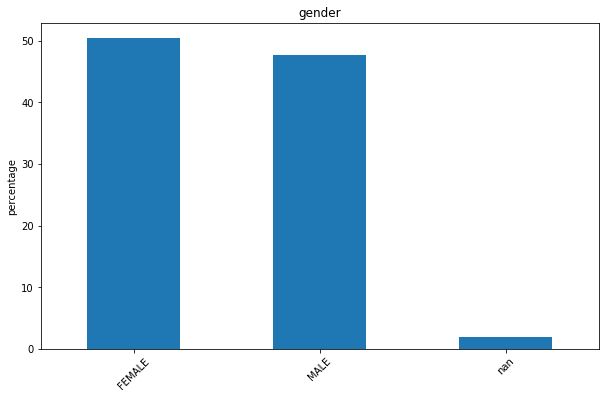

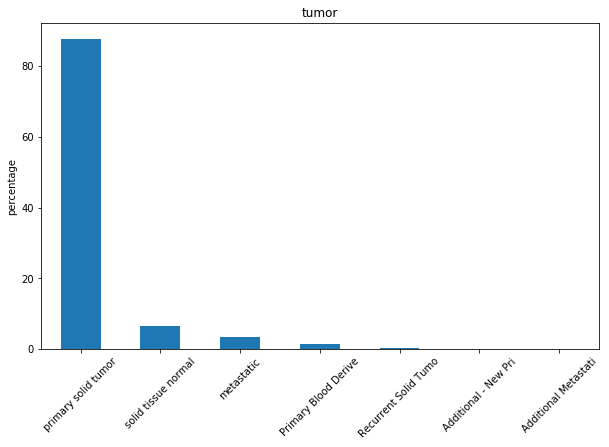

In [103]:
for each_label in ["tissue", "gender", "tumor"]:
    label_name = "label_" + each_label
    (label_df[label_name].value_counts(dropna=False)/\
     float(label_df.shape[0])*100).plot.bar(figsize=(10,6))
    plt.title(each_label)
    plt.xticks(rotation=45)
    plt.ylabel("percentage")
    plt.show()

In [104]:
label_df.to_csv("./data/labels.csv")